Required Code Blocks Before Task 6 & Task 9

The following blocks must be executed before Task 6 (Classical ML Models) and Task 9 (Results, Window Size Sweep).
They provide all the data structures, preprocessing steps, and feature-extraction functions used by later tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from scipy.signal import butter, filtfilt
from scipy.fft import rfft, rfftfreq

plt.rcParams["figure.figsize"] = (10,4)
plt.rcParams["axes.grid"] = True 


C:\Users\hanna\AppData\Local\Temp\ipykernel_23796\2394526955.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def load_raw_sensor(pattern, prefix):
    files = glob.glob(pattern)
    dfs = []

    for path in files:
        df = pd.read_csv(
            path,
            header=None,
            names=["user", "activity", "timestamp", "x", "y", "z"]
        )
        df["z"] = df["z"].astype(str).str.replace(";", "", regex=False)
        df[["x","y","z"]] = df[["x","y","z"]].astype(float)

        df = df.rename(columns={
            "x": f"{prefix}_x",
            "y": f"{prefix}_y",
            "z": f"{prefix}_z",
        })
        dfs.append(df)

    return pd.concat(dfs, ignore_index=True)

# WATCH SENSORS
watch_acc  = load_raw_sensor("wisdm-dataset/raw/watch/accel/*.txt", "w_acc")
watch_gyro = load_raw_sensor("wisdm-dataset/raw/watch/gyro/*.txt",  "w_gyro")

# PHONE SENSORS
phone_acc  = load_raw_sensor("wisdm-dataset/raw/phone/accel/*.txt", "p_acc")
phone_gyro = load_raw_sensor("wisdm-dataset/raw/phone/gyro/*.txt",  "p_gyro")

# MERGE – use OUTER so we don’t lose rows
df_all = watch_acc.merge(watch_gyro, on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_acc,  on=["user","activity","timestamp"], how="outer")
df_all = df_all.merge(phone_gyro, on=["user","activity","timestamp"], how="outer")

print(df_all.shape)
print(df_all["activity"].unique()[:20])  # first few activity codes


(9854871, 15)
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'O' 'P' 'Q' 'R' 'S']


In [3]:
hand_activities = [
    "P",  # dribbling
    "O",  # playing catch
    "F",  # typing
    "Q",  # writing
    "R",  # clapping
    "G",  # brushing teeth
    "S",  # folding clothes
    "J",  # eating pasta
    "H",  # eating soup
    "L",  # eating sandwich
    "I",  # eating chips
    "K"   # drinking
]

df_all["activity"] = df_all["activity"].astype(str).str.strip()
df_hand = df_all[df_all["activity"].isin(hand_activities)].copy()
df_hand = df_hand.reset_index(drop=True)

df_hand["activity"].value_counts()


activity
P    572389
K    571651
O    566768
H    548889
S    548165
R    547468
G    545602
I    543510
L    535868
Q    531434
F    517955
J    509715
Name: count, dtype: int64

In [4]:
FS = 20
sensor_cols = [
    "w_acc_x","w_acc_y","w_acc_z",
    "w_gyro_x","w_gyro_y","w_gyro_z",
    "p_acc_x","p_acc_y","p_acc_z",
    "p_gyro_x","p_gyro_y","p_gyro_z"
]


In [5]:
def butter_lowpass_filter(x, cutoff=5, fs=FS, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype="low")
    return filtfilt(b, a, x)

df_raw = df_hand.copy()

# Interpolate missing values and apply low-pass filter
for col in sensor_cols:
    df_hand[col] = df_hand[col].interpolate(method="linear")
    df_hand[col] = butter_lowpass_filter(df_hand[col].values)


In [6]:
def create_windows(df, window_size=180, overlap=0.5):
    step = int(window_size * (1.0 - overlap))
    X, y = [], []

    signals = df[sensor_cols].values
    acts = df["activity"].values

    for start in range(0, len(df) - window_size, step):
        end = start + window_size
        window = signals[start:end]
        label = pd.Series(acts[start:end]).mode()[0]

        X.append(window)
        y.append(label)

    return np.array(X), np.array(y)


In [7]:
windows, labels = create_windows(df_hand, window_size=180, overlap=0.5)
windows.shape, labels.shape


((72659, 180, 12), (72659,))

In [8]:
def time_features_1d(x):
    mean = np.mean(x)
    sd   = np.std(x)
    rms  = np.sqrt(np.mean(x**2))

    signs = np.sign(x)
    signs[signs == 0] = 1
    zcr = np.sum(signs[1:] != signs[:-1]) / len(x)

    return [mean, sd, rms, zcr]

def freq_features_1d(x, fs=FS):
    N = len(x)
    yf = rfft(x)
    xf = rfftfreq(N, 1.0 / fs)

    power = np.abs(yf) ** 2

    idx = np.argmax(power[1:]) + 1
    dom_freq = xf[idx]

    energy = np.sum(power)

    p = power / (energy + 1e-12)
    entropy = -np.sum(p * np.log(p + 1e-12))

    return [dom_freq, energy, entropy]


In [9]:
def extract_features_window(window):
    feats = []
    for c in range(window.shape[1]):  # 12 channels
        x = window[:, c]
        feats.extend(time_features_1d(x))
        feats.extend(freq_features_1d(x))
    return np.array(feats)


In [10]:
X = np.array([extract_features_window(w) for w in windows])
y = labels

X.shape, len(y)


((72659, 84), 72659)

In [11]:
feature_names = []

for ch in sensor_cols:
    for f in ["mean", "std", "rms", "zcr", "domfreq", "spec_energy", "spec_entropy"]:
        feature_names.append(f"{ch}_{f}")

len(feature_names)


84

## **Task 6 — Modeling**

In this task, we implemented and evaluated several **classical machine learning models** and prepared the dataset for **deep learning** experiments.

### **1. Data Cleaning and Preprocessing**
Before training, we identified and removed any **fully missing (NaN) feature columns**.
All infinite values were replaced with NaNs to ensure compatibility with imputers.  
A `SimpleImputer` (median or mean) was included in each model pipeline to handle missing data consistently.

### **2. Model Setup**
We trained and compared six classical machine learning models:

- **Decision Tree**
- **Support Vector Machine (RBF kernel)**
- **Gaussian Naive Bayes**
- **Random Forest**
- **AdaBoost**
- **XGBoost** (installed and added conditionally)

Each model was implemented using `scikit-learn` pipelines that included preprocessing steps such as imputation and standardization (for SVM).  
A **stratified 80/20 train–test split** was applied to maintain class balance across splits.

### **3. Training and Evaluation**
All models were trained on the same data split for fair comparison.  
A shared evaluation function was used to:
- Compute **accuracy**, **macro-F1**, and **weighted-F1** scores  
- Generate detailed **classification reports**  
- Plot **confusion matrices** for each model  

The overall results were compiled into a **leaderboard**, sorted by macro-F1 and accuracy.  
Performance metrics were visualized using bar plots for easier comparison.

### **4. Deep Learning Input Preparation**
To extend the preprocessing pipeline for deep learning:
- Raw sensor **window sequences** (`windows` array of shape *(N, T, C)*) were normalized **per channel** using global mean and standard deviation.  
- Labels were **encoded** (integer + one-hot) for compatibility with neural network frameworks.  
- The data was split into **training (70%)**, **validation (15%)**, and **test (15%)** sets while preserving class balance.  

Metadata such as class names, number of classes, sequence length, and normalization statistics were stored for later use in ANN models.

### **5. Summary**
- Implemented and evaluated six classical machine learning models.  
- Ensured consistent preprocessing (imputation, scaling, encoding).  
- Compared model performances using macro-F1 and accuracy.  
- Prepared normalized sequential data and encoded labels for deep learning.  
- Generated a leaderboard and visualizations to summarize results.  



In [12]:
import numpy as np
import pandas as pd

# Identify fully-missing columns
mask_all_nan = np.all(np.isnan(X), axis=0)
print("Columns fully NaN:", np.where(mask_all_nan)[0])

# Drop them
X = X[:, ~mask_all_nan]
feature_names = np.array(feature_names)[~mask_all_nan]
print("New X shape:", X.shape)


Columns fully NaN: [42 43 44 47 48 49 50 51 54 55 56 57 58 61 62 63 64 65 68 69 70 71 72 75
 76 77 78 79 82 83]
New X shape: (72659, 54)


In [13]:
import importlib, subprocess, sys

try:
    import xgboost
    print(" XGBoost already installed:", xgboost.__version__)
except ImportError:
    print(" Installing XGBoost...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost
    print("XGBoost installed:", xgboost.__version__)


 XGBoost already installed: 3.1.1


(58127, 54) (14532, 54)  | classes: ['F' 'G' 'H' 'I' 'J' 'K' 'L' 'O' 'P' 'Q' 'R' 'S']

Model: DecisionTree
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.9278    0.9488    0.9382      1152
           G     0.9134    0.9472    0.9300      1213
           H     0.8671    0.8514    0.8592      1218
           I     0.8237    0.8244    0.8240      1207
           J     0.8504    0.8474    0.8489      1134
           K     0.8579    0.8505    0.8542      1271
           L     0.7866    0.7800    0.7833      1191
           O     0.9319    0.9348    0.9333      1258
           P     0.9440    0.9529    0.9484      1273
           Q     0.9284    0.9221    0.9252      1181
           R     0.9639    0.9433    0.9534      1216
           S     0.9240    0.9187    0.9214      1218

    accuracy                         0.8938     14532
   macro avg     0.8933    0.8935    0.8933     14532


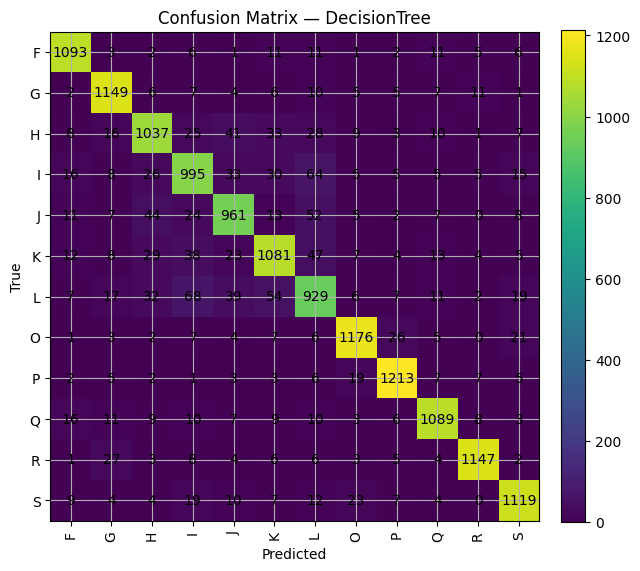


Model: SVM_RBF
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.7186    0.7891    0.7522      1152
           G     0.8190    0.7387    0.7768      1213
           H     0.6650    0.6404    0.6524      1218
           I     0.6786    0.6437    0.6607      1207
           J     0.6034    0.6949    0.6459      1134
           K     0.5668    0.7246    0.6360      1271
           L     0.6603    0.5810    0.6181      1191
           O     0.8644    0.8466    0.8554      1258
           P     0.9009    0.9356    0.9179      1273
           Q     0.8230    0.7832    0.8026      1181
           R     0.8324    0.7558    0.7922      1216
           S     0.8739    0.7849    0.8270      1218

    accuracy                         0.7445     14532
   macro avg     0.7505    0.7432    0.7448     14532
weighted avg     0.7517    0.7445    0.7460     14532



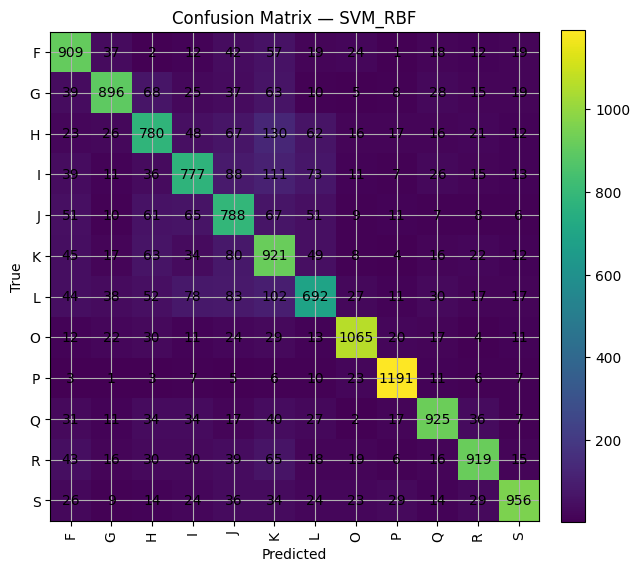


Model: NaiveBayes_Gaussian
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.0894    0.0234    0.0371      1152
           G     0.2379    0.0610    0.0971      1213
           H     0.0893    0.0443    0.0592      1218
           I     0.0429    0.0050    0.0089      1207
           J     0.1255    0.8536    0.2188      1134
           K     0.1017    0.2211    0.1394      1271
           L     0.0123    0.0008    0.0016      1191
           O     0.4410    0.1010    0.1643      1258
           P     0.5211    0.3983    0.4515      1273
           Q     0.1553    0.0288    0.0486      1181
           R     0.3386    0.1587    0.2161      1216
           S     0.2430    0.1133    0.1545      1218

    accuracy                         0.1658     14532
   macro avg     0.1998    0.1674    0.1331     14532
weighted avg     0.2028    0.1658    0.1349     14532



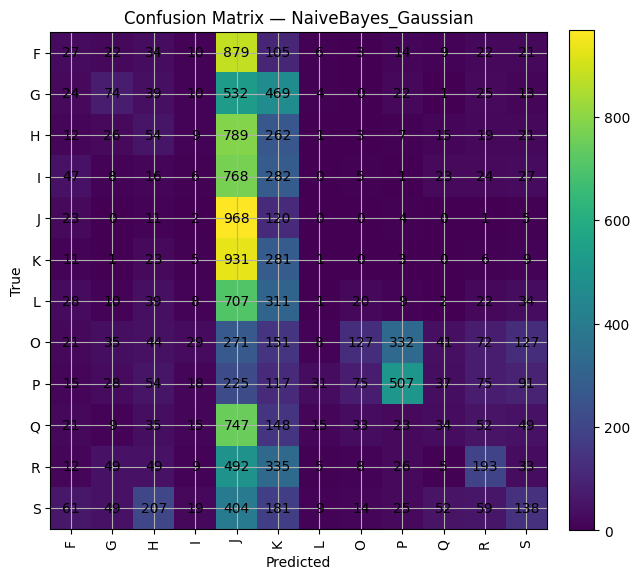


Model: RandomForest
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.9527    0.9792    0.9658      1152
           G     0.9866    0.9728    0.9797      1213
           H     0.9330    0.9376    0.9353      1218
           I     0.9124    0.9056    0.9089      1207
           J     0.9091    0.9347    0.9217      1134
           K     0.9226    0.9284    0.9255      1271
           L     0.9291    0.8581    0.8922      1191
           O     0.9731    0.9793    0.9762      1258
           P     0.9849    0.9741    0.9795      1273
           Q     0.9637    0.9661    0.9649      1181
           R     0.9860    0.9852    0.9856      1216
           S     0.9413    0.9745    0.9576      1218

    accuracy                         0.9498     14532
   macro avg     0.9495    0.9496    0.9494     14532
weighted avg     0.9499    0.9498    0.9497     14532



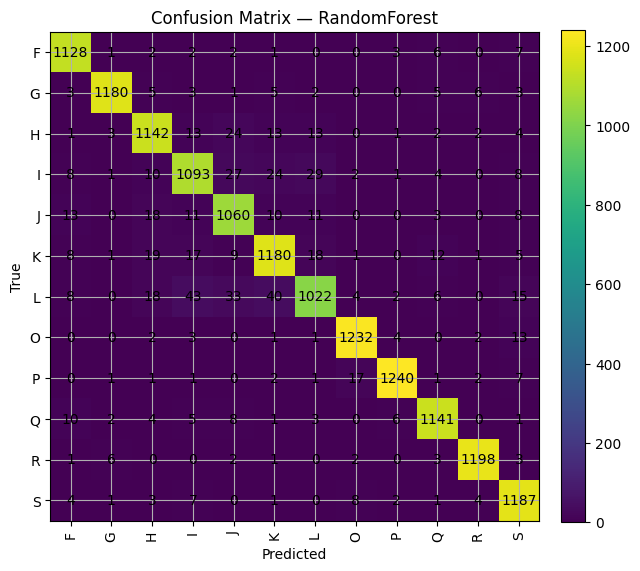


Model: AdaBoost
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.3175    0.5217    0.3947      1152
           G     0.4410    0.2894    0.3494      1213
           H     0.1586    0.1502    0.1543      1218
           I     0.3707    0.2055    0.2644      1207
           J     0.2848    0.3430    0.3112      1134
           K     0.2100    0.4563    0.2876      1271
           L     0.1363    0.0571    0.0805      1191
           O     0.2658    0.0771    0.1195      1258
           P     0.4296    0.5899    0.4972      1273
           Q     0.4935    0.2887    0.3643      1181
           R     0.4597    0.2911    0.3565      1216
           S     0.2820    0.4212    0.3378      1218

    accuracy                         0.3080     14532
   macro avg     0.3208    0.3076    0.2931     14532
weighted avg     0.3207    0.3080    0.2930     14532



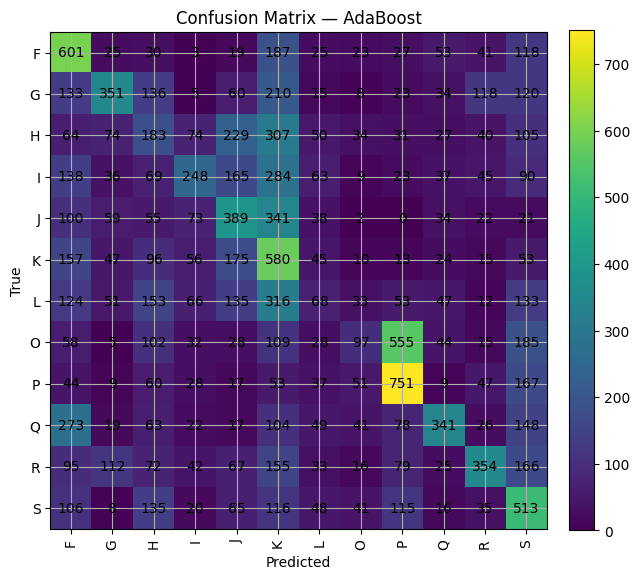


Model: XGBoost
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           F     0.9566    0.9766    0.9665      1152
           G     0.9824    0.9654    0.9738      1213
           H     0.9336    0.9228    0.9282      1218
           I     0.8889    0.8882    0.8885      1207
           J     0.8957    0.9242    0.9097      1134
           K     0.9070    0.9284    0.9176      1271
           L     0.8931    0.8346    0.8628      1191
           O     0.9762    0.9762    0.9762      1258
           P     0.9881    0.9811    0.9846      1273
           Q     0.9659    0.9602    0.9631      1181
           R     0.9794    0.9794    0.9794      1216
           S     0.9404    0.9713    0.9556      1218

    accuracy                         0.9427     14532
   macro avg     0.9423    0.9424    0.9422     14532
weighted avg     0.9427    0.9427    0.9425     14532



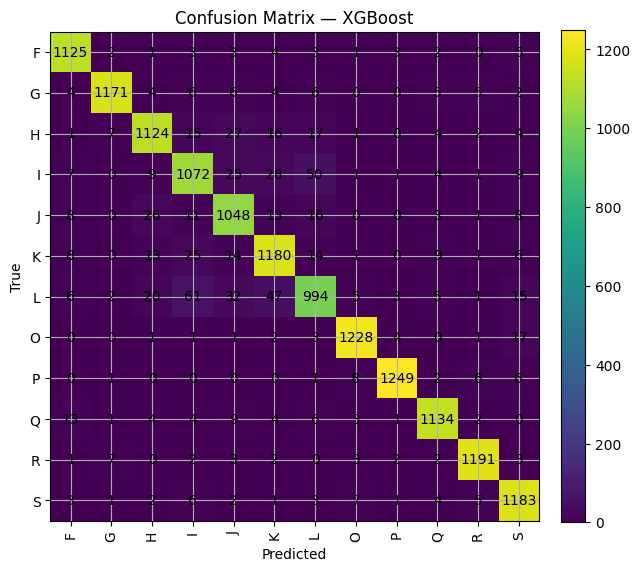

Leaderboard (sorted by F1-macro then Accuracy):
              model  accuracy  f1_macro  f1_weighted
       RandomForest  0.949835  0.949409     0.949677
            XGBoost  0.942678  0.942164     0.942525
       DecisionTree  0.893821  0.893299     0.893682
            SVM_RBF  0.744495  0.744780     0.746015
           AdaBoost  0.308010  0.293127     0.293043
NaiveBayes_Gaussian  0.165841  0.133096     0.134905


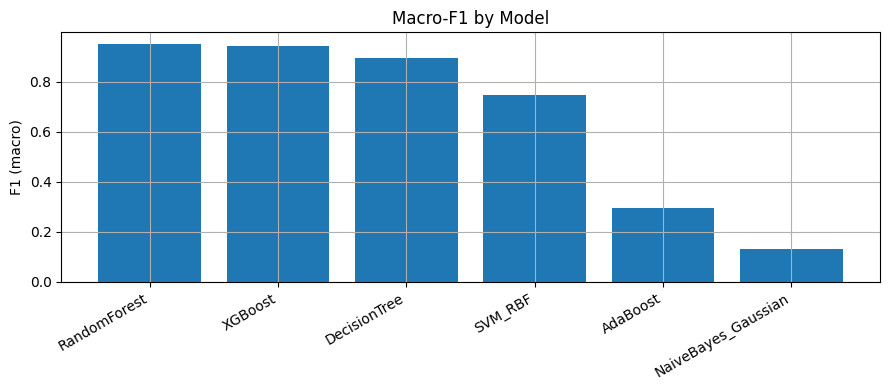

Deep Learning sequence shapes:
  X_train_seq: (50861, 180, 12)  y_train_int: (50861,)
  X_val_seq:   (10899, 180, 12)  y_val_int:   (10899,)
  X_test_seq:  (10899, 180, 12)  y_test_int:  (10899,)


In [14]:

## Task 6 — Classical ML Models + Deep Learning Input Prep (WISDM)
# Run these cells  after feature extraction.

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Any

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier


# ## 1) Single split shared by all classical models
# Keeps the comparison fair (same train/test across models).


# Encode string labels -> integers 0..C-1
le_global = LabelEncoder()
y_enc = le_global.fit_transform(y)          
class_names = le_global.classes_             
num_classes = len(class_names)

# Single split shared by all models
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print(X_train.shape, X_test.shape, " | classes:", class_names)



# ## 2) Helper — evaluation & reporting
# Prints a classification report, draws a confusion matrix, and returns summary metrics.


def evaluate_model(model, name: str) -> Dict[str, Any]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_weighted = f1_score(y_test, y_pred, average="weighted")

    print("\n" + "="*80)
    print(f"Model: {name}")
    print("-"*80)
    print(classification_report(
        y_test, y_pred, target_names=class_names, digits=4
    ))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
    fig, ax = plt.subplots(figsize=(6.5, 6))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(f"Confusion Matrix — {name}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels(class_names, rotation=90)
    ax.set_yticklabels(class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha='center', va='center')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    return {
        "model": name,
        "accuracy": acc,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "estimator": model,
    }



# ## 3) Define classical models
# - Decision Tree
# - SVM (RBF) with `StandardScaler`
# - Gaussian Naive Bayes
# - Random Forest (balanced)
# - AdaBoost
# - XGBoost (if installed)

# Replace +/- inf with NaN so the imputer can handle them
X = np.where(np.isfinite(X), X, np.nan)

models = [
    ("DecisionTree", make_pipeline(
        SimpleImputer(strategy="median"),
        DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=2, random_state=42)
    )),

    ("SVM_RBF", make_pipeline(
        SimpleImputer(strategy="median"),
        StandardScaler(),
        SVC(C=10.0, kernel="rbf", gamma="scale", probability=False, random_state=42)
    )),

    ("NaiveBayes_Gaussian", make_pipeline(
        SimpleImputer(strategy="mean"),   
        GaussianNB()
    )),

    ("RandomForest", make_pipeline(
        SimpleImputer(strategy="median"),
        RandomForestClassifier(n_estimators=300, class_weight="balanced",
                               max_features="sqrt", random_state=42, n_jobs=-1)
    )),

    ("AdaBoost", make_pipeline(
    SimpleImputer(strategy="median"),
    AdaBoostClassifier(
        n_estimators=300,
        learning_rate=0.5,
        algorithm="SAMME",   
        random_state=42
        )
    )),

]


# XGBoost can handle NaNs but we keep imputer for consistency
models.append(("XGBoost", make_pipeline(
     SimpleImputer(strategy="median"),
    XGBClassifier(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
        objective="multi:softmax", 
        num_class=len(np.unique(y)),  
        random_state=42, n_jobs=-1, tree_method="hist"
    )
)))



# ## 4) Train/evaluate all models + leaderboard
results = []
for name, est in models:
    try:
        res = evaluate_model(est, name)
        results.append(res)
    except Exception as e:
        print(f"[Warning] {name} failed: {e}")

leaderboard = pd.DataFrame(results).sort_values(by=["f1_macro", "accuracy"], ascending=False)
print("Leaderboard (sorted by F1-macro then Accuracy):")
print(leaderboard[["model", "accuracy", "f1_macro", "f1_weighted"]].to_string(index=False))

plt.figure(figsize=(9,4))
plt.bar(leaderboard["model"], leaderboard["f1_macro"])  
plt.title("Macro-F1 by Model")
plt.ylabel("F1 (macro)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


# ## 5) Deep Learning input prep (sequences)
# Produces normalized sequences and encoded labels, with train/val/test splits.

# Encode labels to integers 0..C-1
le = LabelEncoder()
labels_int = le.fit_transform(labels)
class_names = list(le.classes_)
num_classes = len(class_names)

# Normalize per-channel over the entire dataset
win = windows.astype(np.float32)           
N, T, C = win.shape
ch_mean = win.reshape(-1, C).mean(axis=0)
ch_std  = win.reshape(-1, C).std(axis=0) + 1e-8
win_norm = (win - ch_mean) / ch_std

# One-hots (for Keras); integers are fine for PyTorch CE loss
enc = OneHotEncoder(sparse_output=False)
Y_onehot = enc.fit_transform(labels_int.reshape(-1,1))

X_train_seq, X_temp_seq, y_train_int, y_temp_int = train_test_split(
    win_norm, labels_int, test_size=0.3, random_state=42, stratify=labels_int
)
X_val_seq, X_test_seq, y_val_int, y_test_int = train_test_split(
    X_temp_seq, y_temp_int, test_size=0.5, random_state=42, stratify=y_temp_int
)

Y_train_oh = enc.transform(y_train_int.reshape(-1,1))
Y_val_oh   = enc.transform(y_val_int.reshape(-1,1))
Y_test_oh  = enc.transform(y_test_int.reshape(-1,1))

print("Deep Learning sequence shapes:")
print("  X_train_seq:", X_train_seq.shape, " y_train_int:", y_train_int.shape)
print("  X_val_seq:  ", X_val_seq.shape,   " y_val_int:  ", y_val_int.shape)
print("  X_test_seq: ", X_test_seq.shape,  " y_test_int: ", y_test_int.shape)

DL_META = {
    "class_names": class_names,
    "num_classes": num_classes,
    "seq_len": T,
    "num_channels": C,
    "channel_mean": ch_mean,
    "channel_std": ch_std,
}



Leaderboard summary:

              model  accuracy  f1_macro  f1_weighted
       RandomForest  0.949835  0.949409     0.949677
            XGBoost  0.942678  0.942164     0.942525
       DecisionTree  0.893821  0.893299     0.893682
            SVM_RBF  0.744495  0.744780     0.746015
           AdaBoost  0.308010  0.293127     0.293043
NaiveBayes_Gaussian  0.165841  0.133096     0.134905


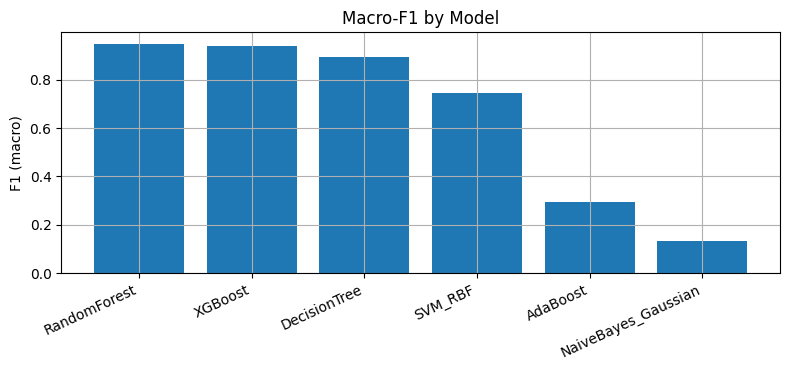

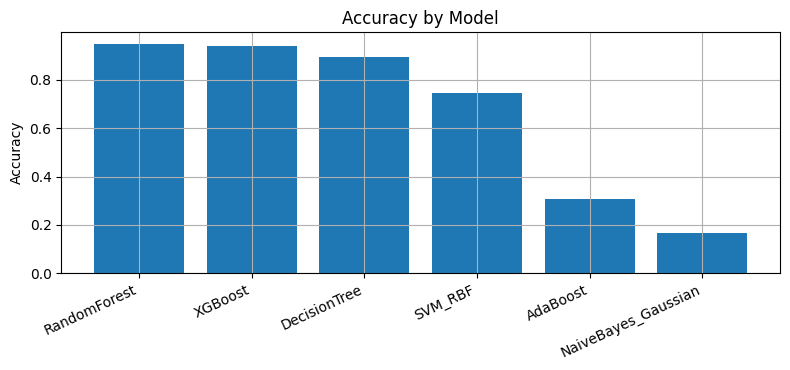

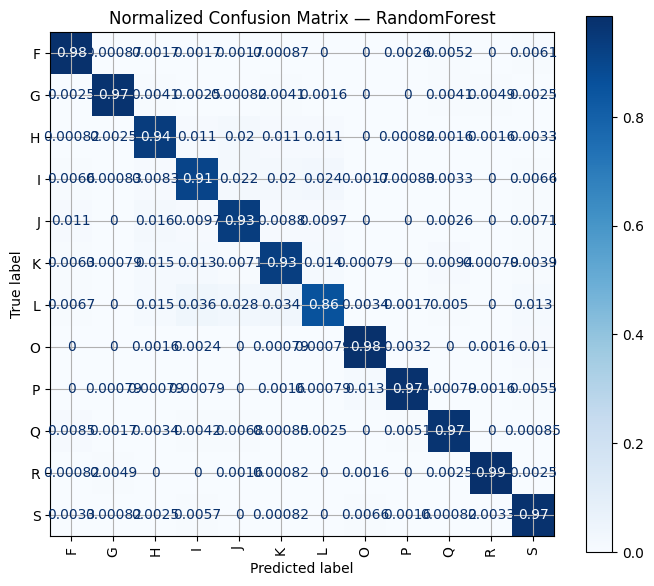

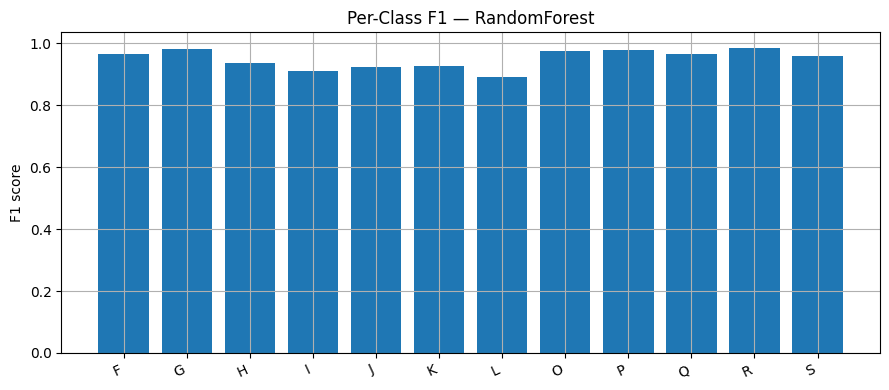

Best Model: RandomForest
Classification report (best model):
              precision    recall  f1-score   support

           F     0.9527    0.9792    0.9658      1152
           G     0.9866    0.9728    0.9797      1213
           H     0.9330    0.9376    0.9353      1218
           I     0.9124    0.9056    0.9089      1207
           J     0.9091    0.9347    0.9217      1134
           K     0.9226    0.9284    0.9255      1271
           L     0.9291    0.8581    0.8922      1191
           O     0.9731    0.9793    0.9762      1258
           P     0.9849    0.9741    0.9795      1273
           Q     0.9637    0.9661    0.9649      1181
           R     0.9860    0.9852    0.9856      1216
           S     0.9413    0.9745    0.9576      1218

    accuracy                         0.9498     14532
   macro avg     0.9495    0.9496    0.9494     14532
weighted avg     0.9499    0.9498    0.9497     14532



In [15]:

# # Task 9 — Report: Results Plots and Model Descriptions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support

# Safety: rebuild a compact results frame if needed
if 'leaderboard' not in globals() or leaderboard is None or leaderboard.empty:
    try:
        leaderboard = pd.DataFrame(results)
    except Exception:
        leaderboard = pd.DataFrame([])

if not leaderboard.empty:
    lb = leaderboard.copy()
    # Keep only public columns, sorted by macro-F1 then accuracy
    keep_cols = [c for c in ["model", "accuracy", "f1_macro", "f1_weighted"] if c in lb.columns]
    lb = lb[keep_cols].sort_values(["f1_macro", "accuracy"], ascending=False)
else:
    lb = pd.DataFrame([])

print("\nLeaderboard summary:\n")
if not lb.empty:
    print(lb.to_string(index=False))
else:
    print("No leaderboard found — run Task 6 first.")

# ## 9.1 Overall Performance Plots
# Bar charts for macro-F1 and accuracy across all classical models.

# %%
if not lb.empty:
    plt.figure(figsize=(8, 3.8))
    plt.bar(lb["model"], lb["f1_macro"])  # default colors only
    plt.title("Macro-F1 by Model")
    plt.ylabel("F1 (macro)")
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 3.8))
    plt.bar(lb["model"], lb["accuracy"])  # default colors only
    plt.title("Accuracy by Model")
    plt.ylabel("Accuracy")
    plt.xticks(rotation=25, ha='right')
    plt.tight_layout()
    plt.show()


# ## 9.2 Best Model: Confusion Matrix & Per-Class Scores


if not lb.empty:
    # Find the stored estimator in `results` matching best by f1_macro
    best_name = lb.iloc[0]["model"]
    best_entry = None
    for r in results:
        if r.get("model") == best_name:
            best_entry = r
            break

    if best_entry is not None:
        best_est = best_entry["estimator"]
        # Access the global split from Task 6
        y_pred_best = best_est.predict(X_test)

        # Normalized confusion matrix
        # y_test / y_pred_best are integers 0..num_classes-1 from Task 6 (LabelEncoder)
        cm = confusion_matrix(
            y_test,
            y_pred_best,
            labels=np.arange(num_classes),   # <-- use encoded label indices
            normalize="true"
        )

        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=class_names       # <-- readable labels (e.g., ['F','G',...,'S'] or full names)
        )

        fig, ax = plt.subplots(figsize=(7, 6))
        disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation=90, colorbar=True)
        ax.set_title(f"Normalized Confusion Matrix — {best_name}")
        plt.tight_layout()
        plt.show()


        # Per-class F1 bar chart
        labels_idx = np.arange(num_classes)  # 0..num_classes-1
        pr, rc, f1, sup = precision_recall_fscore_support(
            y_test, y_pred_best, labels=labels_idx, zero_division=0
        )

# Show codes (['F','G',...]) or map to full names if you have activity_code2name
        class_display = class_names  # or [activity_code2name.get(c, c) for c in class_names]

        plt.figure(figsize=(9, 4))
        plt.bar(range(num_classes), f1)              # numeric positions
        plt.xticks(range(num_classes), class_display, rotation=25, ha='right')
        plt.title(f"Per-Class F1 — {best_name}")
        plt.ylabel("F1 score")
        plt.tight_layout()
        plt.show()

        # Text report (for copy/paste into papers)
        print(f"Best Model: {best_name}")
        print("Classification report (best model):")
        print(classification_report(y_test, y_pred_best, target_names=class_names, digits=4))

    else:
        print("Could not locate the best estimator in `results`. Re-run Task 6.")
else:
    print("Leaderboard empty — run Task 6 first.")


[Info] Dropping 30 all-NaN features for WS=20
WS= 20 | segs=653940 | acc=0.9229 | prec=0.9231 | rec=0.9227 | F1=0.9225
[Info] Dropping 30 all-NaN features for WS=40
WS= 40 | segs=326969 | acc=0.9330 | prec=0.9329 | rec=0.9327 | F1=0.9325
[Info] Dropping 30 all-NaN features for WS=60
WS= 60 | segs=217979 | acc=0.9395 | prec=0.9392 | rec=0.9393 | F1=0.9390
[Info] Dropping 30 all-NaN features for WS=80
WS= 80 | segs=163484 | acc=0.9450 | prec=0.9446 | rec=0.9447 | F1=0.9445
[Info] Dropping 30 all-NaN features for WS=100
WS=100 | segs=130787 | acc=0.9456 | prec=0.9453 | rec=0.9453 | F1=0.9452
[Info] Dropping 30 all-NaN features for WS=120
WS=120 | segs=108989 | acc=0.9446 | prec=0.9441 | rec=0.9443 | F1=0.9440
[Info] Dropping 30 all-NaN features for WS=140
WS=140 | segs=93419 | acc=0.9470 | prec=0.9468 | rec=0.9468 | F1=0.9466
[Info] Dropping 30 all-NaN features for WS=160
WS=160 | segs=81741 | acc=0.9487 | prec=0.9485 | rec=0.9486 | F1=0.9484
[Info] Dropping 30 all-NaN features for WS=180

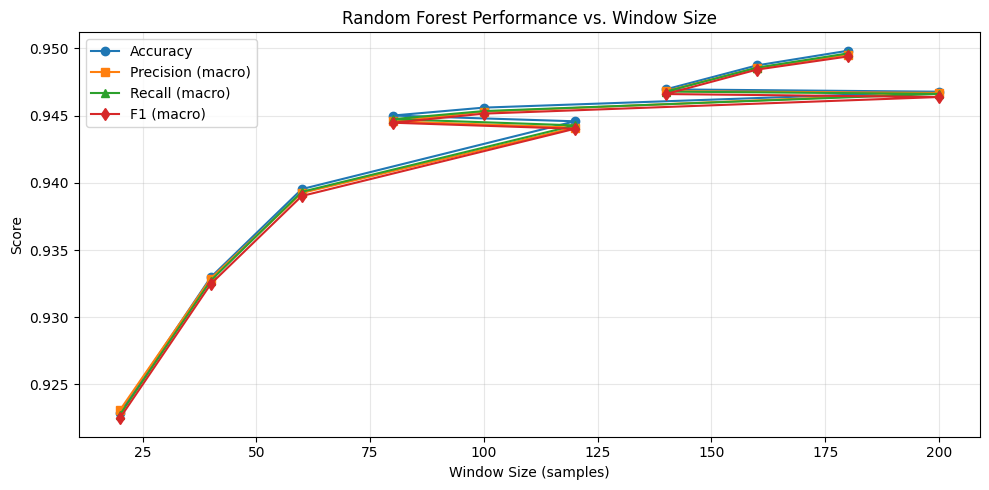

In [16]:
# ## RF vs. Window Size — evaluation sweep (with Precision & Recall)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

warnings.filterwarnings("ignore", message="Skipping features without any observed values")

# Window sizes to evaluate (samples)
WINDOW_SIZES = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
rf_ws_results = []

for ws in WINDOW_SIZES:
    # Build windows & labels for this window size
    X_win, y_win = create_windows(df_hand, window_size=ws, overlap=0.5)
    if len(X_win) == 0:
        print(f"[Skip] Window size {ws}: produced 0 segments.")
        continue

    # Feature extraction
    X_feat = np.array([extract_features_window(w) for w in X_win], dtype=float)
    y_feat = np.array(y_win)

    # Handle inf/nan values
    X_feat = np.where(np.isfinite(X_feat), X_feat, np.nan)
    # Drop all-NaN columns before training
    nan_mask = np.all(np.isnan(X_feat), axis=0)
    if nan_mask.any():
        print(f"[Info] Dropping {nan_mask.sum()} all-NaN features for WS={ws}")
        X_feat = X_feat[:, ~nan_mask]

    #  Encode labels to integers
    le = LabelEncoder()
    y_enc = le.fit_transform(y_feat)

    #  Train/test split
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_feat, y_enc, test_size=0.2, random_state=42, stratify=y_enc
    )

    # Random Forest model
    rf = make_pipeline(
        SimpleImputer(strategy="median"),
        RandomForestClassifier(
            n_estimators=300,
            class_weight="balanced",
            max_features="sqrt",
            random_state=42,
            n_jobs=-1,
        )
    )

    #  Train & evaluate
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    f1_macro = f1_score(y_te, y_pred, average="macro")
    prec_macro = precision_score(y_te, y_pred, average="macro", zero_division=0)
    rec_macro = recall_score(y_te, y_pred, average="macro", zero_division=0)

    rf_ws_results.append({
        "window_size": ws,
        "segments": len(X_win),
        "accuracy": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro
    })

    print(f"WS={ws:3d} | segs={len(X_win):5d} | acc={acc:.4f} | prec={prec_macro:.4f} | rec={rec_macro:.4f} | F1={f1_macro:.4f}")

# Summary table
rf_ws_leaderboard = pd.DataFrame(rf_ws_results).sort_values(
    ["f1_macro", "accuracy"], ascending=False
).reset_index(drop=True)

print("\nRandom Forest — Window Size Sweep (sorted by Macro-F1):")
print(rf_ws_leaderboard.to_string(index=False))

# 9️ Plot Accuracy, Precision, Recall, and F1 vs. window size
plt.figure(figsize=(10,5))
plt.plot(rf_ws_leaderboard["window_size"], rf_ws_leaderboard["accuracy"], "o-", label="Accuracy")
plt.plot(rf_ws_leaderboard["window_size"], rf_ws_leaderboard["precision_macro"], "s-", label="Precision (macro)")
plt.plot(rf_ws_leaderboard["window_size"], rf_ws_leaderboard["recall_macro"], "^-", label="Recall (macro)")
plt.plot(rf_ws_leaderboard["window_size"], rf_ws_leaderboard["f1_macro"], "d-", label="F1 (macro)")

plt.title("Random Forest Performance vs. Window Size")
plt.xlabel("Window Size (samples)")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()